# Definition of a conda environment to work with SIXTE + python + xspec:
==================================================================

        >conda create --name tutorial python  
        >conda activate tutorial    
        >conda install matplotlib jupyterlab pandas astropy
        >conda install -c conda-forge gxx_linux-64==11.1.0  # compatibility issues with xspec/heasoft  
        >conda install krb5 curl  


If you have problems, try this:

- conda update conda
- conda activate tutorial
- conda create --name tutorial python=3.11 matplotlib jupyterlab pandas astropy
- conda install -c conda-forge clang_osx-arm64 gfortran_osx-arm64 # for mac users

Make sure also that you have the **funcs.py** file in your working directory, if not, the function `run_comm` won't work

# 10.2 General Introduction to Simulations with SIXTE


As discussed in more detail in Sect. 1, SIXTE is a Monte Carlo-based tool that can simulate observations of astrophysical sources for a wide variety of different current and future X-ray astronomical satellites. A SIXTE simulation consists of three steps:

1. **Preparation of the input of the simulation, using so-called SIMPUT files (Sect. 2)**:  
   In this step, we define what is to be observed. Typically, this will be a pointed observation of a field on the sky. In the simplest case, this field will only contain one point source, but the simulations also allow for the inclusion of extended sources, time variability, or the simulation of large catalogs of astronomical sources that can contain millions of X-ray sources across the whole sky. Later examples in this and the following sections will present some of the more advanced features.

2. **Running the simulation**:  
   In this step, photons from all sources that are visible to the instrument are generated using a Monte Carlo algorithm (Sect. 3). These photons are then projected onto the focal plane of the instrument using a model of the instrumental optics (Sect. 4) where they are detected using one of the available instrumental models (Sect. 6).

3. **Analyzing the simulation**:  
   The output of the previous step consists of one or multiple standard FITS event files whose structure follows X-ray astronomical standards as specified by NASA’s HEASARC. The output can therefore be analyzed using standard astronomical data analysis packages. SIXTE provides some tools that prepare standard data products such as spectra and images from event files. Alternatively, other tools that can read FITS event files can also be used.

Before we proceed to more complicated examples in the next sections, the following will illustrate how a SIXTE simulation works using a simple observation of a point source.


In [1]:
# import some general packages
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import tempfile
from datetime import datetime
import subprocess
from subprocess import check_call, STDOUT
from funcs import run_comm

# Astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

#XSPEC
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
command = "bash -c 'source $HOME/workspace/Storage/sixte/sixte_volume/sixte_setup.sh && env'"
proc = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, text=True)

for line in proc.stdout:
    key, _, value = line.partition("=")
    os.environ[key] = value.strip()

proc.communicate()

('', None)

In [3]:
# Set the base name for the simulation files
base = "mcrab"

# Define the directory for XML files (specific to the Athena WFI instrument configuration)
home_dir = os.path.expanduser("~")
xmldir = f"{home_dir}/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter" 

## 10.2.1 Step 0: SIXTE installation setup
## 10.2.2 Step 1: Preparing the SIMPUT file


### Create an xspec model and save it as mcrab.xcm

Power law spectrum: $\Gamma=2.05$ 

Unabsorbed Flux(2-10keV): $2.16 \times 10^{-11} \rm{erg\,cm^{-2}\,s^{-1}}$  

Foregroung absorption: $N_H=2\times 10^{21} \rm{cm^{-2}}$  

XSPEC model: phabs*pegpwrlw

In [4]:
# Example of a xspec file with the model "phabs*pegpwrlw"
AllModels.clear()
base = "mcrab"
xcm = f"{base}.xcm"
# define XSPEC parameters
Xset.abund = "wilm"
Xset.cosmo = "70 0. 0.73"
Xset.xsect = "bcmc"
mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 2.05
mcmod.pegpwrlw.eMin = 2.
mcmod.pegpwrlw.eMax = 10.
mcmod.pegpwrlw.norm = 21.6
mcmod.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpwrlw   PhoIndex 

In [5]:
# Get FLUX value to use in SIMPUTFILE run
AllModels.calcFlux("2. 10.")

 Model Flux 0.0033181 photons (2.1306e-11 ergs/cm^2/s) range (2.0000 - 10.000 keV)


In [6]:
simput_flux = AllModels(1).flux[0]
print("Simput Flux=", simput_flux)

Simput Flux= 2.1306205892040244e-11


In [7]:
clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm):
    if clobber:
        os.remove(xcm)
    else:
        raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten") 
# Save the model to the specified .xcm file path
Xset.save(xcm)
print(f"Model saved to {xcm}")

Model saved to mcrab.xcm


### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Add a narrow Gaussian iron line at an energy of 6.4 keV with an equivalent width of 150 eV to the spectrum.

In [8]:
AllModels.clear()
AllData.clear()
mcmodG = Model("phabs*pegpwrlw + ga")
mcmodG.phabs.nH = 0.2
mcmodG.pegpwrlw.PhoIndex = 2.05
mcmodG.pegpwrlw.eMin = 2.
mcmodG.pegpwrlw.eMax = 10.
mcmodG.pegpwrlw.norm = 21.6
mcmodG.gaussian.LineE = 6.4
mcmodG.gaussian.Sigma = 0.001
mcmodG.gaussian.norm = 3.01e-5 # modify this value as needed to get the 150eV equivalent width
mcmodG.show()
AllModels.eqwidth(3) # value is only stored if spectrum is loaded (which is not)



Model phabs<1>*pegpwrlw<2> + gaussian<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
   6    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   7    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   8    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> + gaussian<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpw

In [9]:
clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm):
    if clobber:
        os.remove(xcm)
    else:
        raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten") 
# Save the model to the specified .xcm file path
Xset.save(xcm)
print(f"Model saved to {xcm}")

Model saved to mcrab.xcm


### Create SIMPUT FILE for source (``simputfile``)

In [10]:
simputfile = f"{base}.fits"
xcmfile = f"{base}.xcm"

comm = (f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} Elow=0.1 Eup=15. " +
        f"NBins=1000 Emin=2 Emax=10. XSPECFile={xcmfile} clobber=yes")
#print(comm)
run_comm(comm, "Creating simputfile")

Creating simputfile
simputfile Simput=mcrab.fits Src_Name=first RA=0. Dec=0. srcFlux=2.1306205892040244e-11 Elow=0.1 Eup=15. NBins=1000 Emin=2 Emax=10. XSPECFile=mcrab.xcm clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw + gaussian  ;              0.2      0.001          0        

### <span style="color:blue"> $\textbf{Exercise}$</span>: 
#### Generate a second SIMPUT file for our source, using the plPhoIndex, plFlux, and NH parameters rather than an xcm-file. Compare both SIMPUT-files using fv. **Note this step only works if you have ISIS installed**


In [11]:
simputfile = f"{base}_wo-xcm.fits"

comm = (f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} Elow=0.1 Eup=15. " +
        f"Emin=2 Emax=10. clobber=yes plPhoIndex=2.05 plFlux=21.6 NH=0.2")
print(comm)
run_comm(comm, "Creating simputfile")

simputfile Simput=mcrab_wo-xcm.fits Src_Name=first RA=0. Dec=0. srcFlux=2.1306205888361613e-11 Elow=0.1 Eup=15. Emin=2 Emax=10. clobber=yes plPhoIndex=2.05 plFlux=21.6 NH=0.2


## 10.2.3 An aside: Inspecting FITS-files with (HEASOFT)/Astropy tools


In [11]:
simputfile = f"{base}.fits"
f = fits.open(simputfile)
f.info()
f[1].columns.names
f.close()

Filename: mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   


In [12]:
simputfile = f"{base}_wo-xcm.fits"
f = fits.open(simputfile)
f.info()
f[1].columns.names
f.close()

Filename: mcrab_wo-xcm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   


## 10.2.4 Step2: Running the simulation

### Simulate with WFI one large chip (``sixtesim``)

In [13]:
xml = f"{xmldir}/ld_wfi_ff_large.xml"
evtfile = f"sim_evt_{base}.fits"
simputfile = f"{base}.fits"

comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0.  Simput={simputfile} EvtFile={evtfile} Exposure=1000 clobber=yes")
print(comm)
run_comm(comm, "Simulating source with  WFI  instrument")

sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0.  Simput=mcrab.fits EvtFile=sim_evt_mcrab.fits Exposure=1000 clobber=yes
Simulating source with  WFI  instrument
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0.  Simput=mcrab.fits EvtFile=sim_evt_mcrab.fits Exposure=1000 clobber=yes
initialize ...
Seed = 1953327341
try to load all spectra ('mcrab.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|

*** Warning in convSimputMIdpSpecWithARF: the spectrum 'mcrab.fits[SPECTRUM,1]' does not cover the full energy range of the ARF! ***
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Modify your SIMPUT-file to cover the full energy range of the ARF. 
##### Note that you actually have to go slightly past the limits listed in the ARF because the energy grid of the spectrum is generated at the midpoints of the bins from Elow to Eup.


### Create the new SIMPUT file with `simputfile` tool

In [14]:
simputfile = f"{base}.fits"
xcmfile = f"{base}.xcm"
        
comm = (f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} Elow=0.01 Eup=20. "
        f"NBins=1000 Emin=2 Emax=10. XSPECFile={xcmfile} clobber=yes")
#print(comm)
run_comm(comm, "Creating simputfile")

Creating simputfile
simputfile Simput=mcrab.fits Src_Name=first RA=0. Dec=0. srcFlux=2.1306205892040244e-11 Elow=0.01 Eup=20. NBins=1000 Emin=2 Emax=10. XSPECFile=mcrab.xcm clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw + gaussian  ;              0.2      0.001          0       

### Run again the simulation with `sixtesim`

In [15]:
evtfile = f"sim_evt_{base}.fits"

comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simputfile} EvtFile={evtfile} Exposure=1000 clobber=yes")
print(comm)
run_comm(comm, "Simulating source with  WFI  instrument")

sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab.fits EvtFile=sim_evt_mcrab.fits Exposure=1000 clobber=yes
Simulating source with  WFI  instrument
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab.fits EvtFile=sim_evt_mcrab.fits Exposure=1000 clobber=yes
initialize ...
Seed = 2125970761
try to load all spectra ('mcrab.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up ...
finished successfully!



## 10.2.5 Step 3: Analyzing the simulation (``imgev`` and ``makespec``)

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Take a lookat the structure of the event file. How many events were simulated? Speculate on the meaning of the individual columns in the event file 

In [16]:
evtfile = f"sim_evt_{base}.fits"
f = fits.open(evtfile)
f.info()

# events
data = f["EVENTS"].data
nevents = data.shape[0]
print("\nNumber of simulated events:{}\n".format(nevents))

# columns 
print("Columns in event file:")
f[1].columns.names

Filename: sim_evt_mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  EVENTS        1 BinTableHDU    120   87312R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   

Number of simulated events:87312

Columns in event file:


['TIME',
 'FRAME',
 'PHA',
 'PI',
 'SIGNAL',
 'RAWX',
 'RAWY',
 'RA',
 'DEC',
 'PH_ID',
 'SRC_ID',
 'TYPE',
 'NPIXELS',
 'PILEUP',
 'SIGNALS',
 'PHAS']

In [17]:
# close event file
f.close()

### Create an image (`imgev`)
The `Projection` argument defines the map projection that is to be used. All projections allowed by the FITS standard are allowed here. For most applications and for pointed observations, the tangential projection, `TAN`, is recommended.
The `NAXIS`-keywords give the number of x- and y-pixels in the picture. `CRVAL1` and `CRVAL2` define the center of the map. They should, in general, equal the pointing direction of the simulated observation. `CRPIX1` and `CRPIX2` are the point corresponding to the optical axis on the instrument. These depend on the instrument that is being simulated. Finally, `CDELT1` and `CDELT2` define the spatial resolution of the detector (that is, one detector pixel on the WFI has a size of about 2.2'' × 2.2'').


In [18]:
# create image
imgfile = f"img_{base}.fits"
        
comm = (f"imgev EvtFile={evtfile} Image={imgfile} CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 " +
        f"CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 " +
        f"CDELT2=6.207043e-04 history=true clobber=yes")  
print(comm)
run_comm(comm, "Creating WFI image")

imgev EvtFile=sim_evt_mcrab.fits Image=img_mcrab.fits CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
Creating WFI image
imgev EvtFile=sim_evt_mcrab.fits Image=img_mcrab.fits CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04 history=true clobber=yes
initialize ...
open event file 'sim_evt_mcrab.fits' ...
finished successfully!



The image produced by imgev can be viewed with standard astronomical image viewers such as **ds9** or **fv**. In
our current case, it is rather boring – we just have a point source.

Text(0.5, 1.0, 'Central source zoom')

<Figure size 800x600 with 0 Axes>

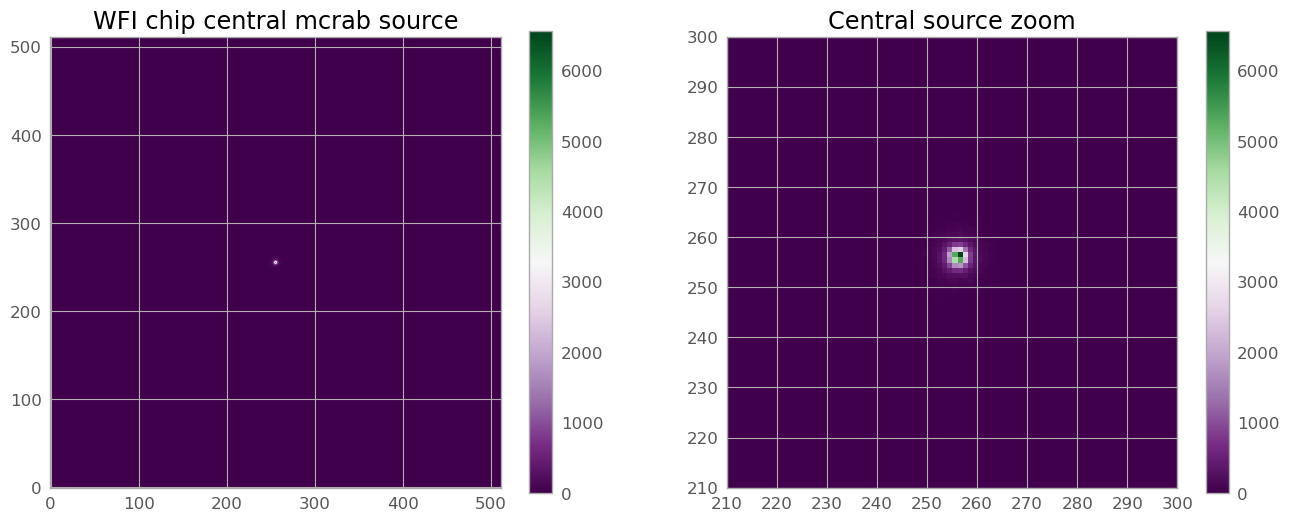

In [19]:
# Plot image
plt.clf()
#plt.rcParams['axes.grid'] = False # to avoid a warning about axes grids in latest versions of matplotlib
plt.rcParams['axes.grid'] = True
image_data = fits.getdata(imgfile, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs = _axs.flatten()
cmap = plt.cm.PRGn

# Left plot
im = axs[0].imshow(image_data, cmap=cmap, origin="lower")
fig.colorbar(im,ax=axs[0])

# Zoomed plot
im = axs[1].imshow(image_data[210:300, 210:300], extent=[210,300, 210,300], cmap=cmap, origin="lower")
fig.colorbar(im,ax=axs[1])

# Titles
axs[0].set_title("WFI chip central mcrab source")
axs[1].set_title("Central source zoom")


### Create an spectrum (`makespec`)

#### Use select events based on columns in a FITS file using logical expressions

In [20]:
# Create spectrum filtering the events with the condition given by "EventFilter" 
specfile = f"spec_{base}.pha"

comm = (f"makespec EvtFile={evtfile} Spectrum={specfile} clobber=yes RSPPath={xmldir} " + 
        f"EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' ")
# The selection expression uses the standard C-syntax for logicals, i.e., && means a logical AND, || means a logical OR, and parentheses can be used.
#print(comm)
run_comm(comm, "Creating spectum with WFI")

Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab.fits Spectrum=spec_mcrab.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' 
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 2222987915
calculate spectrum ...
store spectrum ...


#### Use a **ds9** region file. For this, you first have to add X,Y sky coordinates and a WCS to the event file with the (`radec2xy`) tool.

In [21]:
comm = (f"radec2xy EvtFile={evtfile} projection=TAN RefRA=0 RefDec=0")
# define the WCS reference point (which should in general correspond to the pointing direction)
#print(comm)
run_comm(comm, "Adding X,Y sky coordinates")


Adding X,Y sky coordinates
radec2xy EvtFile=sim_evt_mcrab.fits projection=TAN RefRA=0 RefDec=0
initialization ...
open event file 'sim_evt_mcrab.fits' ...
add XY coordinates to event file ...
 ... adding X, Y coordinates successful!
cleaning up ...
finished successfully!



Now with **ds9** select a region and create de regfile


In [22]:
regfile = f"ds9_{base}.reg"
src_radius = 5. # radius in arcseconds
reg = (0.0, 0.0, src_radius) 

with open(regfile, 'w') as f:
    f.write(f'fk5\n')
    f.write(f'circle({reg[0]},{reg[1]},{reg[2]}") # text={{Core}}\n')

print(f"Reg file created: {regfile}")

Reg file created: ds9_mcrab.reg


You can then specify the region file in the makespec command with `regfile=ds9.reg`

In [23]:
regfile = f"ds9_{base}.reg"
specfile = f"spec_{base}.pha"

comm = (f"makespec EvtFile={evtfile} Spectrum={specfile} clobber=yes RSPPath={xmldir} " + 
        f"regfile={regfile} ")

print(comm)
run_comm(comm, "Creating spectum with WFI a ds9 region")

makespec EvtFile=sim_evt_mcrab.fits Spectrum=spec_mcrab.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter regfile=ds9_mcrab.reg 
Creating spectum with WFI a ds9 region
makespec EvtFile=sim_evt_mcrab.fits Spectrum=spec_mcrab.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter regfile=ds9_mcrab.reg 
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 2230837121
calculate spectrum ...
store spectrum ...


####  Use vector columns like SRC_ID or PH_ID, with an index starting at 1.

In [24]:
specfile = f"spec_{base}.pha"

# In this case you need to give a valid logical expression, by selecting only one element of the array.
# Important: the array index starts at ’1’. In order to select only background events, the expression would read 'SRC_ID[1]==-1'
comm = f"makespec EvtFile={evtfile} Spectrum={specfile} clobber=yes RSPPath={xmldir} EventFilter='SRC_ID[1]==1'"

#print(comm)
run_comm(comm, "Creating spectum with WFI")

Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab.fits Spectrum=spec_mcrab.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter EventFilter='SRC_ID[1]==1'
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 2237690539
calculate spectrum ...
store spectrum ...


### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Obtain the names of the the response matrix and the ancilliary response matrix (the “RMF” and the “ARF”). These names can be obtained by looking at the values of the RESPFILE and ANCRFILE keywords


In [26]:
f = fits.open(specfile)
f.info()
rmf = f[1].header['RESPFILE']
arf = f[1].header['ANCRFILE']
f.close()
print(f"Response Matrix (RMF):{rmf}")
print(f"Ancilliary Response Matrix (ARF):{arf}")

Filename: spec_mcrab.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   ()      
  1  SPECTRUM      1 BinTableHDU     47   1498R x 2C   [J, J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   
Response Matrix (RMF):/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf
Ancilliary Response Matrix (ARF):/Users/jessicaplanelles/simput/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


In [27]:
#run_comm('ln -s {}'.format(rmf), 'Linking to working directory')
#run_comm('ln -s {}'.format(arf), 'Linking to working directory')

# strip path in keywords to avoid very long values and update header
rmf = os.path.basename(rmf)
arf = os.path.basename(arf)
f = fits.open(specfile, 'update')
f[1].header['RESPFILE'] = rmf
f[1].header['ANCRFILE'] = arf
f.close()

### Analyze the spectrum (XSPEC python interface)

#### 1) fit spectrum in XSPEC


1 spectrum  in use
 
Spectral Data File: spec_mcrab.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.205e+01 +/- 2.864e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1498
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf



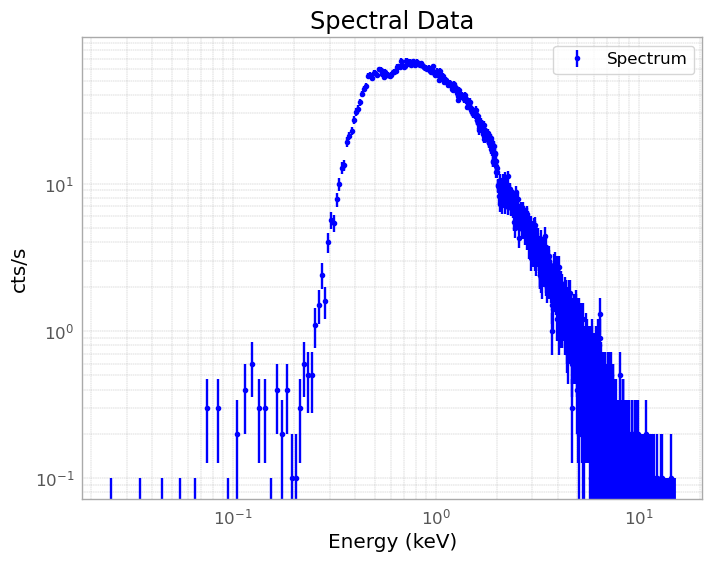

In [25]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s0 = Spectrum(f"spec_{base}.pha")
Plot.device = "/null" # Disable the visualization in XSPEC
Plot.xAxis = "keV"
Plot('data')

energies = Plot.x()
counts = Plot.y()
errors = Plot.yErr()

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("cts/s")
plt.title("Spectral Data")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.3)
plt.show()

Note the “ragged” shape at low and high energies, which is due to the small number of photons detected. Note
also the feature around 2 keV, which is due to the M-edge of iridium in the mirror material of Athena.
To fit the spectrum, we first ignore the energy bands where the signal to noise ratio is small and check that all
went ok by plotting again.

#### 2) ignore energy bands where signal to noise ratio is small

    28 channels (1-28) ignored in spectrum #     1

  1101 channels (398-1498) ignored in spectrum #     1



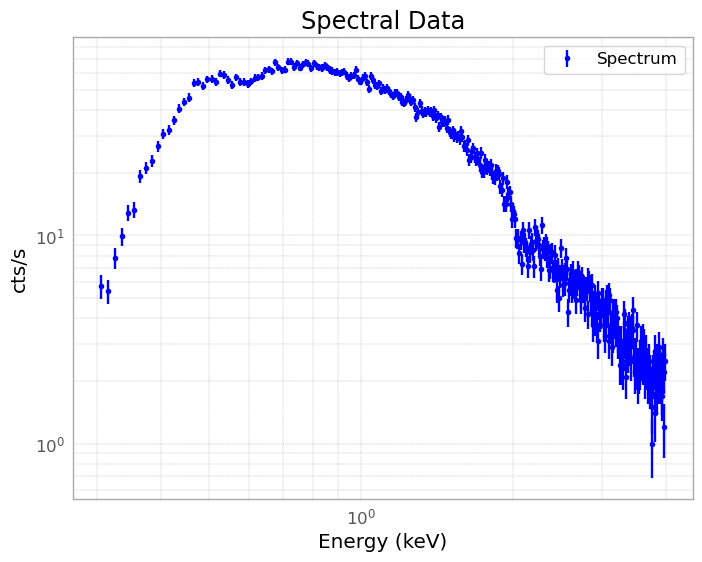

In [26]:
# As there are bins with zero variance: ignore energy bands where signal to noise ratio is small
s0.ignore("**-0.3")
s0.ignore("4.0-**")
Plot('ldata')
energies = Plot.x()
counts = Plot.y()
errors = Plot.yErr()

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("cts/s")
plt.title("Spectral Data")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.3)
plt.show()

#### 3) Define an absorbed power law model

In [30]:
m0 = Model("phabs*pow")


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.203866e+09     using 369 bins.

Test statistic : Chi-Squared              1.203866e+09     using 369 bins.
 Null hypothesis probability of 0.000000e+00 with 366 degrees of freedom
 Current data and model not fit yet.


#### 4) rebin spectral data using `grppha`

In [27]:
binspec = f"spec_{base}_rebin.pha"

comm = (f"grppha infile={specfile} outfile={binspec} clobber=yes comm='group min 20 & exit'")
run_comm(comm, "Rebinning spectrum")

Rebinning spectrum
grppha infile=spec_mcrab.pha outfile=spec_mcrab_rebin.pha clobber=yes comm='group min 20 & exit'
 ** grppha 3.1.0
 ...... using pha_gp   Ver 1.1.1
 
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 1000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /home/idies/workspace/Storage/sixte

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Load rebinned PHA-file into XSPEC and fit an absorbed power-law to the 0.3-4 keV band



1 spectrum  in use
 
Spectral Data File: spec_mcrab_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.205e+01 +/- 2.864e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-865
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      f

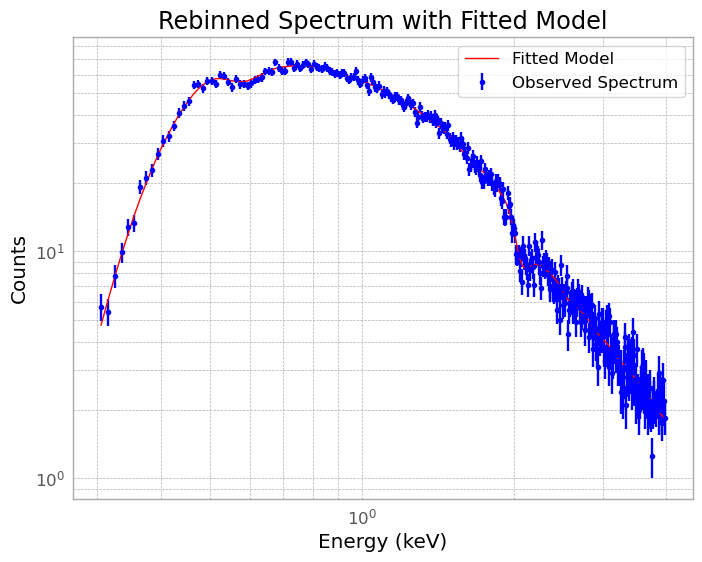

In [28]:
AllData.clear()
AllModels.clear()

s1 = Spectrum(binspec)
m0 = Model("phabs*pegpwrlw")

s1.ignore("**-0.3")
s1.ignore("4.0-**")

Fit.perform()

Plot.device = "/null"  
Plot("ldata")

energies = Plot.x()      
counts = Plot.y()            
errors = Plot.yErr()       
model_counts = Plot.model()   

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Observed Spectrum", color='blue', markersize=3)
plt.plot(energies, model_counts, label="Fitted Model", color='red', linewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Rebinned Spectrum with Fitted Model")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.5)
plt.show()

In [29]:
print(f"nH fit={m0.phabs.nH.values[0]:.3f}")
print(f"Gamma fit={m0.pegpwrlw.PhoIndex.values[0]:.3f}")

nH fit=0.198
Gamma fit=2.048


Fitting the spectrum will yield a photon index of around Γ = 2.039, and not Γ = 2.05 as expected. The reason
for this is that the flux of the source is so bright that interesting detector effects become important. The most
important here is pile up which is caused by the arrival of more than one photon at the same or neighboring
pixels during one read-out cycle of the detector. 

#### 5) check PILEUP

In [30]:
evtfile = f"sim_evt_{base}.fits"
f = fits.open(evtfile)
PILEUP = f[1].data["PILEUP"]
print("The sum of PILEUP column is                  {}".format(np.sum(PILEUP)))
print("The mean of PILEUP column is                 {}".format(PILEUP.mean()))
print("The standard deviation of PILEUP column is   {}".format(PILEUP.std()))
print("The minimum of PILEUP column is              {}".format(PILEUP.min()))
print("The maximum of PILEUP column is              {}".format(PILEUP.max()))
print("The number of points used in calculation is  {}".format(len(PILEUP)))

The sum of PILEUP column is                  599
The mean of PILEUP column is                 0.006860454462158695
The standard deviation of PILEUP column is   0.08254325306608253
The minimum of PILEUP column is              0
The maximum of PILEUP column is              1
The number of points used in calculation is  87312


The value of PILEUP is 1 if more than one photon contributed to the event. In our example, 526 events were
piled up (out of 87816). This means that about 0.6% of all events are affected by pile up, so it is no surprise that
the spectral shape differs from the input spectral shape.

### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### change the pointing direction of the instrument away from the source in steps of 4' in right ascension and declination simultaneously. Take a look at the images of the source and the source count rate. What do you observe?

********************************
Image for offset=0 arcm
********************************
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0.0 Dec=0.0 Prefix='' Simput=mcrab.fits EvtFile=sim_evt_mcrab_dec0.fits Exposure=1000 clobber=yes
Running simulation
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0.0 Dec=0.0 Prefix='' Simput=mcrab.fits EvtFile=sim_evt_mcrab_dec0.fits Exposure=1000 clobber=yes
initialize ...
Seed = 2263359109
try to load all spectra ('mcrab.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up 

<Figure size 800x600 with 0 Axes>

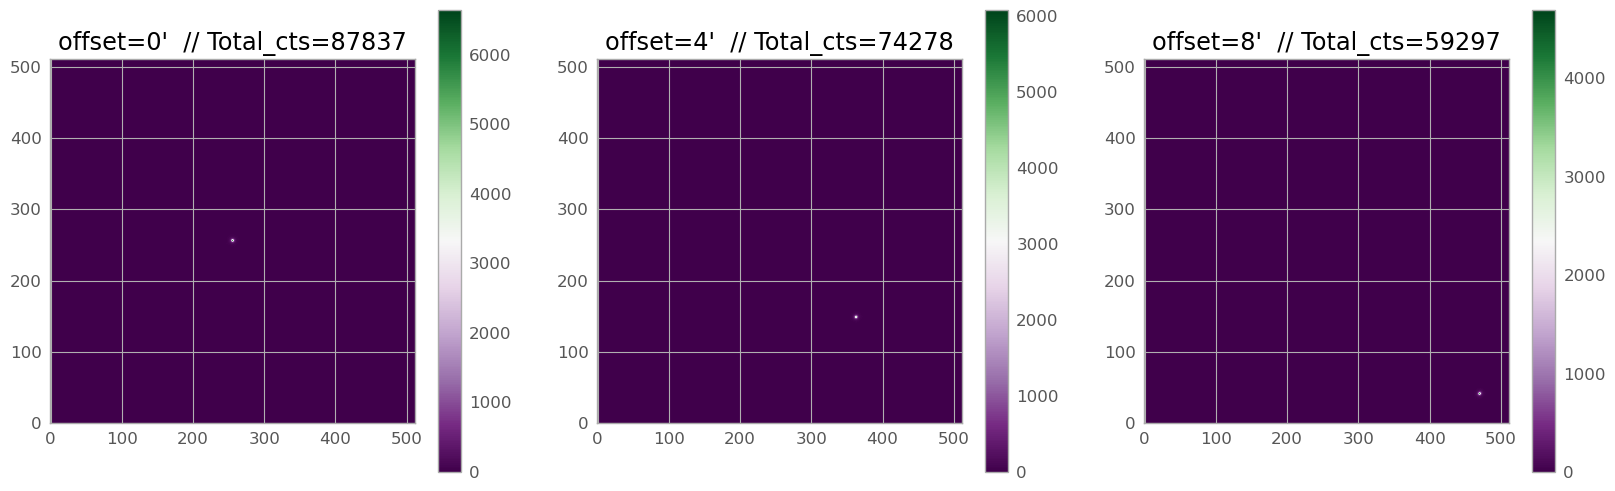

In [31]:
plt.rcParams['axes.grid'] = True # (Set to 'False' to avoid a warning about axes grids in latest versions of matplotlib
# define values for the simulations
noffs = 3 # number of offsets (in steps of 4 arcmin)
xml = f"{xmldir}/ld_wfi_ff_large.xml"

# source is always the same
simputfile = f"{base}.fits"

# change pointing direction
plt.clf()
fig, _axs = plt.subplots(nrows=1, ncols=noffs, figsize=(20,6))
axs = _axs.flatten()
# Plotting 3 images of the source with the telescope moved away 4' and 8'
for ioff in range(0,(noffs*3),4):
    print("********************************")
    print(f"Image for offset={ioff} arcm")
    print("********************************")
    i = int(ioff/3.) 
    base_dec = f"mcrab_dec{ioff}"
    ra_off = ioff/60
    dec_off = ioff/60. #deg
    expos = 1000
    simputfile_dec = f"{base_dec}.simput"
            
    # run simulation
    evtfile_dec = f"sim_evt_{base_dec}.fits"
    comm = (f"sixtesim XMLFile={xml} RA={ra_off} Dec={dec_off} Prefix='' " + 
            f"Simput={simputfile} EvtFile={evtfile_dec} Exposure={expos} clobber=yes")
    print(comm)
    run_comm(comm, "Running simulation")
    
    # create image
    imgfile_dec = f"img_{base_dec}.fits"
    comm = (f"imgev EvtFile={evtfile_dec} Image={imgfile_dec} CoordinateSystem=0 " +
            f"Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1={ra_off} CRVAL2={dec_off} " + 
            f"CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04")
    print(comm)
    run_comm(comm, "Creating image")
    
    image_data = fits.getdata(imgfile_dec, ext=0)
    cmap = plt.cm.PRGn
    
    from astropy.visualization import simple_norm
    #norm = simple_norm(image_data, stretch='log', log_a=10000)
    #im = axs[i].imshow(image_data, origin="lower", cmap=cmap, norm=norm)
    #im = axs[i].imshow(image_data, cmap=cmap, origin="lower", norm=LogNorm(vmax=50))
    im = axs[i].imshow(image_data, cmap=cmap, origin="lower")
    fig.colorbar(im,ax=axs[i])
    tit = f"offset={ioff}'  // Total_cts={np.sum(image_data)}"
    axs[i].set_title(tit)


### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### a) In this exercise we continue studying the effects that bright sources have on the measurement process more. Using the Crab-like spectrum defined before, increase the source flux by a factor of 10, 100, and 1000 and redo the WFI simulation. Why can you prepare the simulation using *mcrab.fits* and `fv`, and without running simputfile?



In [32]:
# Re-using the XSPEC spectra file and thus, the SIMPUT file
simputfile = f"{base}.fits"
flux_ratio = [1, 10, 100, 1000]
nfactors = len(flux_ratio)

# Create new simputfiles modifying the flux from the original simputfile
for factor in flux_ratio:
    new_simputfile = f"{base}_factor{factor}.fits"
    f = fits.open(simputfile)
    initial_flux = f["SRC_CAT"].data["FLUX"]
    f["SRC_CAT"].data["FLUX"] = factor * initial_flux
    f.writeto(new_simputfile, overwrite=True)
    f.close()

In [33]:
# do the simulation: CAREFUL!!! Simulations for FLUX=100*flux and 1000*flux take a long time to run!
xml = f"{xmldir}/ld_wfi_ff_large.xml"
expos = 100
for i in range(nfactors):
    factor = flux_ratio[i]
    new_simputfile = f"{base}_factor{factor}.fits"
    new_evtfile = f"sim_evt_{base}_factor{factor}.fits"
    # Run simulation
    comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={new_simputfile} " + 
            f"EvtFile={new_evtfile} Exposure={expos} clobber=yes")
    print(comm)
    run_comm(comm, "Simulating new fluxes")

sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_factor1.fits EvtFile=sim_evt_mcrab_factor1.fits Exposure=100 clobber=yes
Simulating new fluxes
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_factor1.fits EvtFile=sim_evt_mcrab_factor1.fits Exposure=100 clobber=yes
initialize ...
Seed = 2474957294
try to load all spectra ('mcrab_factor1.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up ...
finished successfully!

sixtesim XMLFile=/home/idies/worksp

#### b) Calculate the count rates of the simulations by looking at the number of events in the file. What do you notice? Take a look at the X-ray spectrum of the 2nd brightest simulation and compare the observed photon spectrum with your input photon index. 

In [37]:
nevents = np.zeros(nfactors)
for i in range(len(flux_ratio)):
    factor = flux_ratio[i]
    new_evtfile = f"sim_evt_{base}_factor{factor}.fits"
    # number of events in the file
    f = fits.open(new_evtfile)
    nevents[i] = f[1].header["NAXIS2"]
    print(f"Count rate for flux factor{factor}: {nevents[i]/expos} cts/s")

Count rate for flux factor1: 88.15 cts/s
Count rate for flux factor10: 691.1 cts/s
Count rate for flux factor100: 2974.16 cts/s
Count rate for flux factor1000: 13999.26 cts/s


In [40]:
# Create spectrum for 2nd brightest simulation (factor=100)
factor = flux_ratio[2]
new_specfile = f"spec_{base}_factor{factor}.pha"
new_evtfile = f"sim_evt_{base}_factor{factor}.fits"

comm = (f"makespec EvtFile={new_evtfile} Spectrum={new_specfile} clobber=yes RSPPath={xmldir} " + 
        f"EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' ")
#print(comm)
run_comm(comm, "Creating spectum with WFI")

Creating spectum with WFI
makespec EvtFile=sim_evt_mcrab_factor100.fits Spectrum=spec_mcrab_factor100.pha clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05' 
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 185836181
calculate spectrum ...
store spectrum ...


In [44]:
# strip path in keywords to avoid very long values
f = fits.open(new_specfile, 'update')
#f[1].header['RESPFILE'] = rmf
#f[1].header['ANCRFILE'] = arf
f.close()

In [45]:
# rebin spectrum
new_binspec = f"spec_{base}_factor{factor}_rebin.pha"
comm = (f"grppha infile={new_specfile} outfile={new_binspec} clobber=yes comm='group min 20 & exit'")    
run_comm(comm, "Rebinning spectrum")

Rebinning spectrum
grppha infile=spec_mcrab_factor100.pha outfile=spec_mcrab_factor100_rebin.pha clobber=yes comm='group min 20 & exit'
 ** grppha 3.1.0
 ...... using pha_gp   Ver 1.1.1
 
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 100.00          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /home/idies/wor


1 spectrum  in use
 
Spectral Data File: spec_mcrab_factor100_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.954e+03 +/- 5.435e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-780
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 100 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.000

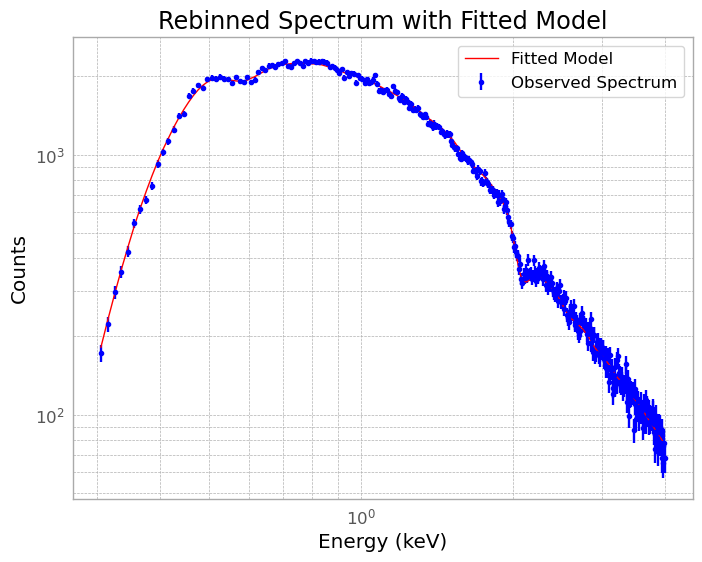

In [46]:
# fit power law 
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s1 = Spectrum(new_binspec)
m0 = Model("phabs*pegpwrlw")
s1.ignore("**-0.3")
s1.ignore("4.0-**")
Fit.perform()

Plot("ldata")
m0.show()

energies = Plot.x()      
counts = Plot.y()            
errors = Plot.yErr()       
model_counts = Plot.model()   

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Observed Spectrum", color='blue', markersize=3)
plt.plot(energies, model_counts, label="Fitted Model", color='red', linewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Rebinned Spectrum with Fitted Model")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.5)
plt.show()

In [47]:
# Get spectral index
print(f"Gamma fit={m0.pegpwrlw.PhoIndex.values[0]:.3f}")

Gamma fit=1.882


The simulated event files contain four additional keywords that provide diagnostic information about the origin of
the events: The keyword `NVALID` gives the total number of events that were classified as valid in the simulation.
However, some of these events could in fact be affected by pile up. The fraction of valid events caused by two or more photons (either hitting the same pixel during one read-out cycle or producing a valid pattern that is
incorrectly assigned to a single photon) is given by `NPVALID`. Similarly, `NINVALID` gives the total number of
rejected events that were correctly classified as invalid during the simulation and `NPINVALI` gives the fraction of
these invalid events affected by pile up.
Typically, the number of valid events `NVALID` is equal to the number of total events in the output event file.
Events classified as invalid are discarded by default during the simulation, but can be included in the output file
by setting the `sixtesim` parameter **SkipInvalids=no**.

### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### To get a better feeling for what is going on, plot the value of the FITS keywords NVALID, NPVALID, NINVALID, and NPINVALI as a function of the input flux. Why is the pile up fraction NPVALID/NVALID a good measure for the scientific quality of the data?

In [48]:
nvalid = np.zeros(nfactors)     # gives the total number of events that were classified as valid in the simulation
npvalid = np.zeros(nfactors)    # fraction of valid events caused by two or more photons (pileup)
ninvalid = np.zeros(nfactors)   # gives the total number of rejected events that were correctly classified as invalid during the simulation
npinvali = np.zeros(nfactors)   #  the fraction of these invalid events affected by pile up

for i in range(nfactors):
    factor = flux_ratio[i]
    new_evtfile = f"sim_evt_{base}_factor{factor}.fits"
    
    # Save the parameters wanted of the event file in an empty list
    f = fits.open(new_evtfile)
    nvalid[i] = (f['EVENTS'].header['NVALID'])
    npvalid[i] = (f['EVENTS'].header['NPVALID'])
    ninvalid[i] = (f['EVENTS'].header['NINVALID'])
    npinvali[i] = (f['EVENTS'].header['NPINVALI'])

    data_quality = npvalid[i]/nvalid[i]
    print("###############################################################")
    print(f"Valid events: {nvalid[i]} of which {npvalid[i]} are piled-up")
    print(f"InValid events: {ninvalid[i]} of which {npinvali[i]} are piled-up")
    print(f"Data quality={data_quality:.3f}")
    print("###############################################################")
    f.close

print(f"NVALID:   {nvalid}")
print(f"NPVALID:  {npvalid}")
print(f"NINVALID: {ninvalid}")
print(f"NPINVALI: {npinvali}")

###############################################################
Valid events: 8815.0 of which 51.0 are piled-up
InValid events: 73.0 of which 70.0 are piled-up
Data quality=0.006
###############################################################
###############################################################
Valid events: 69110.0 of which 3205.0 are piled-up
InValid events: 4963.0 of which 4960.0 are piled-up
Data quality=0.046
###############################################################
###############################################################
Valid events: 297416.0 of which 14302.0 are piled-up
InValid events: 64653.0 of which 64650.0 are piled-up
Data quality=0.048
###############################################################
###############################################################
Valid events: 1399926.0 of which 70987.0 are piled-up
InValid events: 162246.0 of which 162237.0 are piled-up
Data quality=0.051
############################################################

Text(0, 0.5, 'Data Quality')

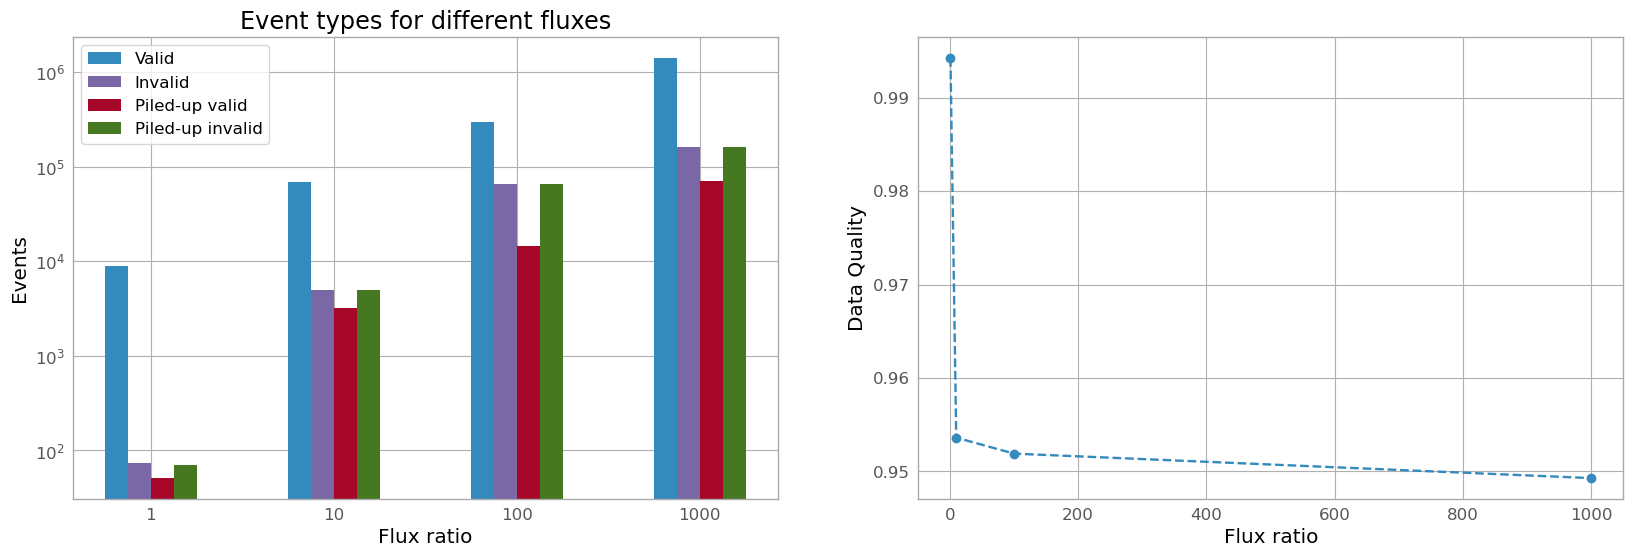

In [49]:
# Plot histogram of the data collected from the different simulations of the 4 fluxes.

fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axs = _axs.flatten()
flux_labels = [str(a) for a in flux_ratio]
x = np.arange(len(flux_labels))
width = 0.25
axs[0].bar(x-0.75*width, nvalid, width/2, log=True, label="Valid")
axs[0].bar(x-width/4, ninvalid, width/2, log=True, label="Invalid")
axs[0].bar(x+width/4, npvalid, width/2, log=True,label="Piled-up valid")
axs[0].bar(x+0.75*width, npinvali, width/2, log=True,label="Piled-up invalid")
axs[0].set_xlabel("Flux ratio")
axs[0].set_ylabel('Events')
axs[0].set_title('Event types for different fluxes')
axs[0].set_xticks(x)
axs[0].set_xticklabels(flux_labels)
axs[0].legend()

data_quality = (1-npvalid/nvalid)

axs[1].plot(flux_ratio, data_quality, marker='o', linestyle='--')
axs[1].set_xlabel("Flux ratio")
axs[1].set_ylabel("Data Quality")

### <span style="color:blue">$\textbf{Exercise}$</span>:  

#### Generate a SIMPUT file with a harder spectral shape (e.g., Γ = 1.5) than our example source and has the same flux. Place the source at a position that is 10" away from our source. Merge both SIMPUT files with the `simputmerge` tool (use `plist` to learn about the parameters of this tool!). Then run a 5 ks simulation and study how well you can separate both sources.

    

In [50]:
# xspec file
AllModels.clear()
AllData.clear()
base_harder = "hardersrc"
xcm_harder = f"{base_harder}.xcm"
mod_harder = Model("phabs*pegpwrlw")
mod_harder.phabs.nH = 0.2
mod_harder.pegpwrlw.PhoIndex = 1.5
mod_harder.pegpwrlw.eMin = 2.
mod_harder.pegpwrlw.eMax = 10.
mod_harder.pegpwrlw.norm = 21.6 # same unabsorbed 2-10 keV flux as initial mcrab source (see Section 10.2.2)
mod_harder.show()
AllModels.calcFlux("2. 10.")
simput_flux_harder = AllModels(1).flux[0]

clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm_harder):
    if clobber:
        os.remove(xcm_harder)
    else:
        raise Exception("Xspec file ({}) already exists: it will not be overwritten".format(xcm_harder)) 
Xset.save(xcm_harder)


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.50000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                21.6000      +/-  0.0     

In [51]:
# simputfile
simputfile10 = f"{base_harder}_10.fits"
ra = 0.0
dec10 = 10.0/3600 #deg
Elow = 0.01 # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

comm = (f"simputfile Simput={simputfile10} Src_Name=first RA={ra} Dec={dec10} srcFlux={simput_flux_harder} " + 
        f"Elow={Elow} Eup={Eup} NBins=1000 Emin={Emin} Emax={Emax} XSPECFile={xcm_harder} clobber=yes")
#print(comm)
run_comm(comm, "Creating simputfile")

Creating simputfile
simputfile Simput=hardersrc_10.fits Src_Name=first RA=0.0 Dec=0.002777777777777778 srcFlux=2.1372154482916442e-11 Elow=0.01 Eup=20 NBins=1000 Emin=2 Emax=10 XSPECFile=hardersrc.xcm clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw  ;              0.2      0.001 

In [52]:
# merge simput files
simput_merged10 = f"{base}_{base_harder}_10_merged.fits"
comm = (f"simputmerge Infile1={simputfile} Infile2={simputfile10} Outfile={simput_merged10} clobber=yes FetchExtensions=yes")
#print(comm)
run_comm(comm, 'Merging original mcrab and newsrc_offset simput files')

Merging original mcrab and newsrc_offset simput files
simputmerge Infile1=mcrab.fits Infile2=hardersrc_10.fits Outfile=mcrab_hardersrc_10_merged.fits clobber=yes FetchExtensions=yes

merging simput files ...
100%

cleaning up ...
finished successfully!



In [53]:
# run 5 ks simulation
expos=5000
xml = f"{xmldir}/ld_wfi_ff_large.xml"
evtfile_merged10 = f"sim_evt_{base}_{base_harder}_10_merged.fits"

comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simput_merged10} " + 
        f"EvtFile={evtfile_merged10} Exposure={expos} clobber=yes")
#print(comm)
run_comm(comm, "Simulating new fluxes")

Simulating new fluxes
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_hardersrc_10_merged.fits EvtFile=sim_evt_mcrab_hardersrc_10_merged.fits Exposure=5000 clobber=yes
initialize ...
Seed = 286192741
try to load all spectra ('mcrab_hardersrc_10_merged.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 

cleaning up ...
finished successfully!



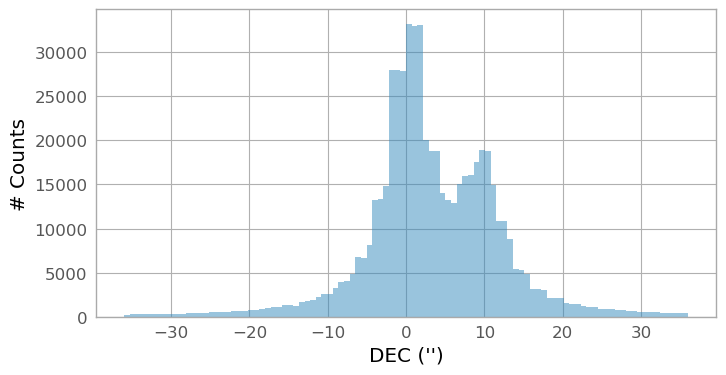

In [54]:
# study source separation (histogram of Dec positions) 
f = fits.open(evtfile_merged10)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("# Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.01) & (decVals<0.01)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)

SIXTE provides the tool `sixte_arfgen` to generate corrected ARFs for sources within a user-supplied region. `ARFcorr` specifies the name of the corrected ARF (the output file of the tool) and XMLFile gives the path
to the XML-File that was used for the simulation. The parameters `RA/Dec` give the pointing of the observation,
`SourceRA/SourceDec` specify the source position and `RefRA/RefDec` specify a reference position needed for
the creation of a WCS system. The `regfile` parameter specifies the region on which the ARF correction should
be applied.

An attitude file can be specified instead of the pointing via the `Attitude` parameter. Specific subsets of the
period described by this attitude can be selected either via the optional `TSTART` and `exposure` parameters or via
the `GTIfile` parameter, which accepts a FITS GTI file.

### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### Repeat the previous exercise for a source separation of 5'' and extract spectra for all sources. Generate corrected ARFs for the sources by adjusting the parameters of the `sixte_arfgen` call above and use your favorite X-ray spectral analysis program to see how the spectral shape is affected.

In [55]:
# simputfile for src at 5"
simputfile5 = f"{base_harder}_5.fits"
ra = 0.0
dec5 = 5.0/3600 #deg
Elow = 0.01 # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

comm = (f"simputfile Simput={simputfile5} Src_Name=first RA={ra} Dec={dec5} srcFlux={simput_flux_harder} " + 
        f"Elow={Elow} Eup={Eup} NBins=1000 Emin={Emin} Emax={Emax} XSPECFile={xcm_harder} clobber=yes")
#print(comm)
run_comm(comm, "Creating simputfile")

Creating simputfile
simputfile Simput=hardersrc_5.fits Src_Name=first RA=0.0 Dec=0.001388888888888889 srcFlux=2.1372154482916442e-11 Elow=0.01 Eup=20 NBins=1000 Emin=2 Emax=10 XSPECFile=hardersrc.xcm clobber=yes
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Thu Aug 22 22:23:14 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw  ;              0.2      0.001  

In [56]:
# merge simput files
simput_merged5 = f"{base}_{base_harder}_5_merged.fits"
comm = (f"simputmerge Infile1={simputfile} Infile2={simputfile5} Outfile={simput_merged5} clobber=yes FetchExtensions=yes")
#print(comm)
run_comm(comm, 'Merging original mcrab and newsrc_offset simput files')

Merging original mcrab and newsrc_offset simput files
simputmerge Infile1=mcrab.fits Infile2=hardersrc_5.fits Outfile=mcrab_hardersrc_5_merged.fits clobber=yes FetchExtensions=yes

merging simput files ...
100%

cleaning up ...
finished successfully!



In [57]:
# run 5 ks simulation
expos=5000
xml = f"{xmldir}/ld_wfi_ff_large.xml"
evtfile_merged5 = f"sim_evt_{base}_{base_harder}_5_merged.fits"

comm = (f"sixtesim XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simput_merged5} " + 
        f"EvtFile={evtfile_merged5} Exposure={expos} clobber=yes")
#print(comm)
run_comm(comm, "Simulating new fluxes")

Simulating new fluxes
sixtesim XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RA=0. Dec=0. Prefix='' Simput=mcrab_hardersrc_5_merged.fits EvtFile=sim_evt_mcrab_hardersrc_5_merged.fits Exposure=5000 clobber=yes
initialize ...
Seed = 913886716
try to load all spectra ('mcrab_hardersrc_5_merged.fits[SPECTRUM,1]') into cache ...

start simulation ...

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


start event pattern analysis ...
start sky projection ...
start Pha2Pi correction ...
run pha2pi correction on event file ... 
### Warning: removing of RawData file failed!

cleaning up ...
finished successfully!



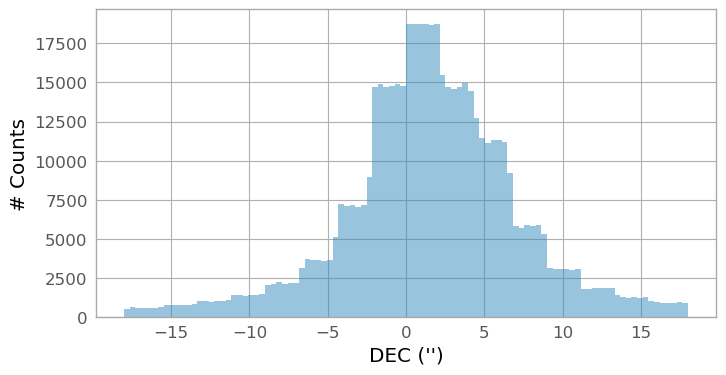

In [58]:
# study source separation (histogram of Dec positions) 
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("# Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.005) & (decVals<0.005)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)

In [59]:
# extract images + define regions + correct ARF
radius = 5. # arcs

for off in (5, 10):
    arfcorr = f"arf_corrected_{off}.fits"
    regcircle = f"circle_{off}.reg"
    offgrad = off/3600.
    image_merged = f"img_{base}_{base_harder}_{off}_merged.fits"
    evtfile_merged = f"sim_evt_{base}_{base_harder}_{off}_merged.fits"

    # extract image
    comm = (f"imgev EvtFile={evtfile_merged} Image={image_merged} CoordinateSystem=0 " +
            f"Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1=0 CRVAL2=0 " + 
            f"CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04")
    #print(comm)
    run_comm(comm, f'Extracting image with src at {off}"')
    
    # define region
    with open(regcircle, 'w') as fw:
        fw.write("fk5\n")
        fw.write(f'circle(0.,{offgrad},{radius}")')
        
    # correct ARF with arfgen tool
    comm = (f"sixte_arfgen ARFCorr={arfcorr} XMLFile={xml} RefRA=0.0 RefDec=0.0 " + 
            f"SourceRA=0.0 SourceDec={offgrad} ImageFile={image_merged} regfile={regcircle}")
    #print(comm)
    run_comm(comm,f'Correcting ARF for src at {off}"')


Extracting image with src at 5"
imgev EvtFile=sim_evt_mcrab_hardersrc_5_merged.fits Image=img_mcrab_hardersrc_5_merged.fits CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 CUNIT1=deg CUNIT2=deg CRVAL1=0 CRVAL2=0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 CDELT2=6.207043e-04
initialize ...
open event file 'sim_evt_mcrab_hardersrc_5_merged.fits' ...
finished successfully!

Correcting ARF for src at 5"
sixte_arfgen ARFCorr=arf_corrected_5.fits XMLFile=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/ld_wfi_ff_large.xml RefRA=0.0 RefDec=0.0 SourceRA=0.0 SourceDec=0.001388888888888889 ImageFile=img_mcrab_hardersrc_5_merged.fits regfile=circle_5.reg
SIXTE version 3.0.7
Seed = 1604117214

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Extracting image with src at 10"
imgev EvtFile=sim_evt_mcrab_hardersrc_10_merged.fits Image

In [69]:
# spectrum of src at 5" and 10"
radInDeg = radius/3600.  # 5" radius
for off in (5, 10):
    RAmin = 360.-radInDeg
    RAmax = 0.+radInDeg
    DECmin = off/3600 - radInDeg
    DECmax = off/3600 + radInDeg
    filt = f"'(RA>{RAmin}|| RA<{RAmax}) && Dec>{DECmin}&& Dec<+{DECmax}'"
    specfile = f"{base_harder}_{off}_spec.fits"
    evtfile_merged = f"sim_evt_{base}_{base_harder}_{off}_merged.fits"
    comm = (f"makespec EvtFile={evtfile_merged} Spectrum={specfile} clobber=yes RSPPath={xmldir} EventFilter={filt}")
    #print(comm)
    run_comm(comm, 'Extracting spectrum of source at 5" ')

Extracting spectrum of source at 5" 
makespec EvtFile=sim_evt_mcrab_hardersrc_5_merged.fits Spectrum=hardersrc_5_spec.fits clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter EventFilter='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>0.0&& Dec<+0.002777777777777778'
SIXTE version 3.0.7
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
Seed = 1835038667
calculate spectrum ...
store spectrum ...
Extracting spectrum of source at 5" 
makespec EvtFile=sim_evt_mcrab_hardersrc_10_merged.fits Spectrum=hardersrc_10_spec.fits clobber=yes RSPPath=/home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter EventFilter='(RA>359.99861111111113|| RA<0.00138888888888

In [64]:
# assign new ARFs in headers
for off in (5,10):
    arfcorr = f"arf_corrected_{off}.fits"
    specfile = f"{base_harder}_{off}_spec.fits"
    f = fits.open(specfile, 'update')
    rmflong = f[1].header['RESPFILE'] 
    rmf = os.path.basename(rmflong)
    f[1].header['RESPFILE'] = rmf 
    f[1].header['ANCRFILE'] = arfcorr
    f.close()

In [70]:
# rebin spectra
for off in (5, 10):
    specfile = f"{base_harder}_{off}_spec.fits"
    rebin = f"{base_harder}_{off}_spec.grp"
    comm = (f"grppha infile={specfile} outfile={rebin} clobber=yes comm='group min 20 & exit'")
    run_comm(comm, f'Rebinning spectrum of src at {off}"')

Rebinning spectrum of src at 5"
grppha infile=hardersrc_5_spec.fits outfile=hardersrc_5_spec.grp clobber=yes comm='group min 20 & exit'
 ** grppha 3.1.0
 ...... using pha_gp   Ver 1.1.1
 
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 5000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /home/idies/wor


1 spectrum  in use
 
Spectral Data File: hardersrc_5_spec.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.104e+01 +/- 1.010e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-934
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 5000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf

    10 channels (1-10) ignored in spectrum #     1

   555 channels (380-934) ignored in spectrum #     1


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   Ph

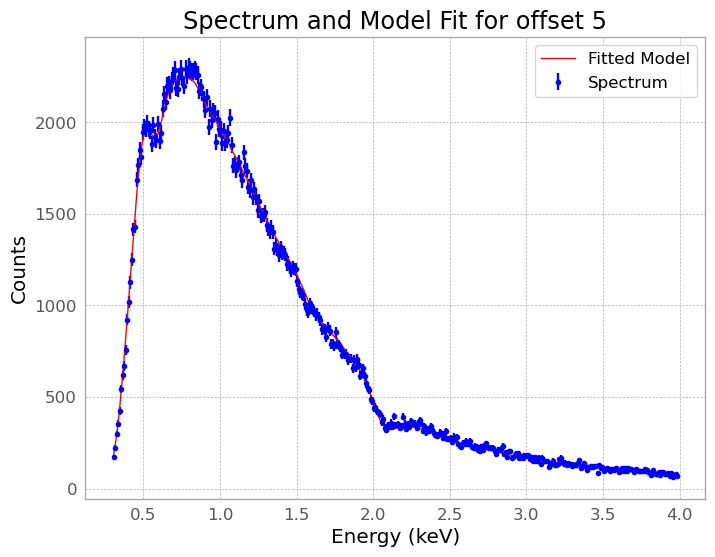


1 spectrum  in use
 
Spectral Data File: hardersrc_10_spec.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.725e+01 +/- 7.382e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-791
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 5000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/idies/workspace/Storage/sixte/sixte_volume/sixtedata/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf

     7 channels (1-7) ignored in spectrum #     1

   415 channels (377-791) ignored in spectrum #     1


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   Ph

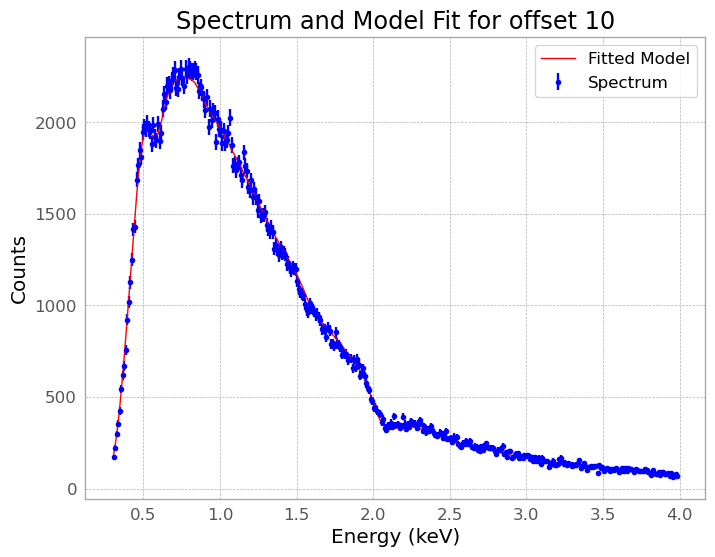

In [71]:
Gammas = dict()

# Fit spectra and plot variations
for off in (5, 10):
    rebin = f"{base_harder}_{off}_spec.grp"
    Plot.device = '/null'  # Suppress external window
    AllData.clear()
    AllModels.clear()

    # Load the model and data
    s0 = Spectrum(rebin)
    s0.ignore("**-0.3")
    s0.ignore("4.0-**")
    m = Model("phabs*pow")

    # Perform the fit and store the Gamma index
    Fit.perform()
    Gammas[off] = m.powerlaw.PhoIndex.values[0]

    energies = Plot.x()
    counts = Plot.y()
    errors = Plot.yErr()
    model_counts = Plot.model()
    
    plt.figure(figsize=(8, 6))
    plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Spectrum", color='blue', markersize=3)
    plt.plot(energies, model_counts, label="Fitted Model", color='red', linewidth=1)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")
    plt.title(f"Spectrum and Model Fit for offset {off}")
    plt.grid(True, which="both", linestyle="--", lw=0.5)
    plt.legend()
    plt.show()

In [72]:
for off in (5, 10):
    print(f'Spectral Index for {off}" source: {Gammas[off]:.3f}')

Spectral Index for 5" source: 1.733
Spectral Index for 10" source: 1.585


### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### In order to quantify the mixing of photons from both sources further, we can take a look at the diagnostic information contained in the event file. Specifically, use the FTOOL `fselect` and, using the row selection syntax, generate a new event file for one of the two sources by selecting the events in the region around the source. Determine the fraction of photons from the other source that “contaminate” the selection region by using the information in the `SRC_ID` column of the event file. For each event, this column contains information about the source in which it originated, in form of the ID of that source in the SIMPUT file.


In [73]:
# get selected events in central source region
evt0 = "sim_evt_0.fits"
radInDeg = 5./3600.
RAmin = 360.-radInDeg
RAmax = 0.+radInDeg

DECmin = 0. - radInDeg
DECmax = 0. + radInDeg
filt = f"'(RA>{RAmin}|| RA<{RAmax}) && Dec>{DECmin}&& Dec<+{DECmax}'"
comm = (f"fselect infile={evtfile_merged5}+1 outfile={evt0} expr={filt} clobber=yes")
run_comm(comm, "Selecting events for source at centre")

# get selected events in 5" offset source region
evt5 = "sim_evt_5.fits"
DECmin = 5./3600 - radInDeg
DECmax = 5./3600 + radInDeg
filt = f"'(RA>{RAmin}|| RA<{RAmax}) && Dec>{DECmin}&& Dec<+{DECmax}'"
comm = (f"fselect infile={evtfile_merged5}+1 outfile={evt5} expr={filt} clobber=yes")
run_comm(comm, 'Selecting events for source at 5" ')
    

Selecting events for source at centre
fselect infile=sim_evt_mcrab_hardersrc_5_merged.fits+1 outfile=sim_evt_0.fits expr='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>-0.001388888888888889&& Dec<+0.001388888888888889' clobber=yes
Selecting events for source at 5" 
fselect infile=sim_evt_mcrab_hardersrc_5_merged.fits+1 outfile=sim_evt_5.fits expr='(RA>359.99861111111113|| RA<0.001388888888888889) && Dec>0.0&& Dec<+0.002777777777777778' clobber=yes


In [74]:
# Total counts (both sources)
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
print("Total number of photons in both sources (central & 5'' offset)=",data.shape[0])
f.close

# Counts from central source
f = fits.open(evt0)
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph = len(idVals)
nph2 =len(idVals[idVals[:,0]==2][:,0])
print(f'SRC1 (central): Number of photons from src2 (5" offset) = {nph2} ({nph2/nph*100:.2f} %)')

# Counts from 5" offset source
f = fits.open(evt5)
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph = len(idVals)
nph1 =len(idVals[idVals[:,0]==1][:,0])
print(f'SRC2 (5" offset): Number of photons from src1 (central) = {nph1} ({nph1/nph*100:.2f} %)')


Total number of photons in both sources (central & 5'' offset)= 635616
SRC1 (central): Number of photons from src2 (5" offset) = 68623 (23.40 %)
SRC2 (5" offset): Number of photons from src1 (central) = 144052 (56.45 %)
